In [1]:
import math
import ast
import heapq
from copy import deepcopy
from math import log
import random
import os
import copy
import time

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision
from torchvision import transforms
from torchsummary import summary
import pkbar

from PIL import Image

import numpy as np
import pandas as pd
from tqdm.autonotebook import tqdm
tqdm.pandas()

from sklearn.preprocessing import MultiLabelBinarizer
from skimage import io
from sklearn.metrics import hamming_loss, accuracy_score
from sklearn.model_selection import train_test_split

from nltk.translate.bleu_score import sentence_bleu
from nltk import FreqDist

import matplotlib.pyplot as plt
plt.ion()   # interactive mode

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
if torch.cuda.is_available():
    print("Using CUDA")
    device = torch.device("cuda")
else:
    print("Using CPU")
    device = torch.device("cpu")

Using CUDA


In [3]:
start_token = '<start>'
end_token = '<end>'
unknown_token = '<unk>'
padding_token = '<pad>'

## Prepare Data

### Products

In [4]:
df = pd.read_csv("data/styles_tags_pred.csv")

In [5]:
df.head()

,id,masterCategory,subCategory,articleType,baseColour,title,tokenized,file_name,tags,tags_pred
0,1163,Apparel,Topwear,Tshirts,Blue,Nike Sahara Team India Fanwear Round Neck Jersey,"['<start>', 'nike', 'sahara', 'team', 'india',...",1163.jpg,"['nike', 'team', 'india', 'round', 'neck', 'je...","[2.3143535e-07, 2.3702476e-09, 2.986898e-07, 3..."
1,1164,Apparel,Topwear,Tshirts,Blue,Nike Men Blue T20 Indian Cricket Jersey,"['<start>', 'nike', 'men', 'blue', 'indian', '...",1164.jpg,"['nike', 'men', 'blue', 'indian', 'cricket', '...","[2.2555818e-07, 1.8278894e-09, 7.16435e-09, 3...."
2,1165,Apparel,Topwear,Tshirts,Blue,Nike Mean Team India Cricket Jersey,"['<start>', 'nike', 'mean', 'team', 'india', '...",1165.jpg,"['nike', 'team', 'india', 'cricket', 'jersey']","[0.00035982736, 2.8710444e-06, 5.1504063e-05, ..."
3,1525,Accessories,Bags,Backpacks,Navy Blue,Puma Deck Navy Blue Backpack,"['<start>', 'puma', 'deck', 'navy', 'blue', 'b...",1525.jpg,"['puma', 'navy', 'blue', 'backpack']","[1.9060193e-05, 8.293974e-09, 9.6082715e-08, 2..."
4,1526,Accessories,Bags,Backpacks,Black,Puma Big Cat Backpack Black,"['<start>', 'puma', 'big', 'cat', 'backpack', ...",1526.jpg,"['puma', 'big', 'cat', 'backpack', 'black']","[0.0015358106, 1.2226741e-07, 7.6661183e-07, 9..."


In [6]:
df.groupby("masterCategory").count()

,id,subCategory,articleType,baseColour,title,tokenized,file_name,tags,tags_pred
masterCategory,,,,,,,,,
Accessories,11286,11286,11286,11286,11286,11286,11286,11286,11286
Apparel,21395,21395,21395,21389,21395,21395,21395,21395,21395
Footwear,9220,9220,9220,9220,9220,9220,9220,9220,9220
Free Items,105,105,105,105,105,105,105,105,105
Home,1,1,1,1,1,1,1,1,1
Personal Care,2399,2399,2399,2395,2399,2399,2399,2399,2399
Sporting Goods,25,25,25,25,25,25,25,25,25


In [7]:
removed_master_category = [
    "Home",
    "Sporting Goods",
    "Free Items"
]

df = df[~df.masterCategory.isin(removed_master_category)]

In [8]:
# convert stringified-list-type columns back to list
df.tokenized = df.tokenized.apply(lambda tokens: ast.literal_eval(tokens))
df.tags_pred = df.tags_pred.apply(lambda tags: ast.literal_eval(tags))

In [9]:
labels = df.tokenized
semantic_inputs = df.tags_pred
file_names = df.file_name
categories = df.subCategory

In [10]:
del df

### Word List

In [11]:
# tokens_frequency = FreqDist()
# for tokens in labels:
#     tokens_frequency += FreqDist(tokens)

# word_list = [token for token, freq in tokens_frequency.most_common()]

# word_list = word_list[2:]

# df_word_list = pd.DataFrame({"word_list": sorted(word_list)})

# df_word_list.head()

# df_word_list.to_csv("data/word_list.csv", index=False)

In [12]:
df_word_list = pd.read_csv("data/word_list.csv")

In [13]:
df_word_list.head()

,word_list
0,a-line
1,aaa-chhe
2,aaliya
3,aandhi
4,aaren


### Split Train Val

In [14]:
X_train, X_val, labels_train, labels_val = train_test_split(list(zip(file_names, semantic_inputs)), labels, test_size=0.2, random_state=105, stratify=categories)

In [ ]:
X_train = np.array(X_train)
X_val = np.array(X_val)

In [ ]:
len(X_train)

In [ ]:
file_names_train = X_train[:, 0]
semantic_inputs_train = X_train[:, 1]
file_names_val = X_val[:, 0]
semantic_inputs_val = X_val[:, 1]

In [ ]:
labels_train = list(labels_train)
labels_val = list(labels_val)

In [ ]:
del file_names
del labels
del semantic_inputs
del categories

## Build Vocabulary

### Vocabulary Class

In [ ]:
class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def get_word(self, idx):
        return self.idx2word[idx]

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)


### Build Vocab

In [ ]:
def build_vocab(word_list):
    
    vocab = Vocabulary()
    
    vocab.add_word(start_token)
    vocab.add_word(end_token)
    vocab.add_word(unknown_token)
    vocab.add_word(padding_token)
    
    for word in word_list:
        vocab.add_word(word)
        
    return vocab

In [ ]:
vocab = build_vocab(df_word_list.word_list)

## Build Caption Model

In [ ]:
def split_tensor1d(tensor, split):
    r"""Split 1D of tensor into N split

    Arguments
        tensor (Pytorch.Tensor) : tensor to split
        split  (int) : number of split
    Return
        array of splitted tensor with N elements of array
    """
    return [
        tensor[:split],
        tensor[split: split * 2],
        tensor[split * 2: split * 3],
        tensor[split * 3:],
    ]


def split_tensor2d(tensor, split, front=False):
    r"""Split 2D of tensor into N split of 2D tensor

    Arguments
        tensor (Pytorch.Tensor) : tensor to split
        split  (int) : number of split
        front  (bool) : split axis 0 if True else axis 1
    Return
        array of splitted 2D tensor with N elements of array
    """

    if front:
        return [
            tensor[:split, :],
            tensor[split: split * 2, :],
            tensor[split * 2: split * 3, :],
            tensor[split * 3:, :],
        ]

    return [
        tensor[:, :split],
        tensor[:, split: split * 2],
        tensor[:, split * 2: split * 3],
        tensor[:, split * 3:],
    ]


In [ ]:
def indexto1hot(vocab_len, index):
    #print("index type: ")
    if isinstance(index, int) == False:
        n = len(index)
        #print("making a 1hot encoding of shape: " + str(n) + "," + str(vocab_len) )
        one_hot = np.zeros([n,vocab_len])
        #can this be optimized?
        for i in range(n):
            one_hot[i,index[i]]=1
        
        return one_hot
    else:
        one_hot = np.zeros([vocab_len])
        one_hot[index] = 1
        
        return one_hot

In [ ]:
class AttentionLSTM(nn.Module):
    def __init__(self, dim_word_emb, dim_lang_lstm, dim_image_feats, nb_hidden):
        super(AttentionLSTM, self).__init__()
        
        self.lstm_cell = nn.LSTMCell(dim_lang_lstm+dim_image_feats+dim_word_emb,
                                     nb_hidden,
                                     bias=True)
        
    def forward(self, h1, c1, h2, v_mean, word_emb):
        #print(h2.shape)
        #print(v_mean.shape)
        #print(word_emb.shape)
        input_feats = torch.cat((h2, v_mean, word_emb),dim=1)
        h_out, c_out = self.lstm_cell(input_feats, (h1, c1))
        
        return h_out, c_out


In [ ]:
class Attend(nn.Module):
    def __init__(self, dim_image_feats, dim_att_lstm, nb_hidden):
        super(Attend, self).__init__()
    
        self.fc_image_feats = nn.Linear(dim_image_feats, nb_hidden, bias=False)
        self.fc_att_lstm = nn.Linear(dim_att_lstm, nb_hidden, bias=False)
        self.act_tan = nn.Tanh()
        self.fc_att = nn.Linear(nb_hidden, 1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, image_feats, h1):
        nb_batch, nb_feats, feat_dim = image_feats.size()
        att_lstm_emb = self.fc_att_lstm(h1).unsqueeze(1)
        image_feats_emb = self.fc_image_feats(image_feats)
        all_feats_emb = image_feats_emb + att_lstm_emb.repeat(1,nb_feats,1)

        activate_feats = self.act_tan(all_feats_emb)
        unnorm_attention = self.fc_att(activate_feats)
        normed_attention = self.softmax(unnorm_attention)

        #print(normed_attention.shape)
        #print(nb_feats)
        #print(image_feats.shape)
        #weighted_feats = normed_attention.repeat(1,1,nb_feats) * image_feats
        weighted_feats = normed_attention * image_feats
        #print(weighted_feats.shape)
        attended_image_feats = weighted_feats.sum(dim=1)
        #print(attended_image_feats.shape)
    
        return attended_image_feats


In [ ]:
class SCNCell(nn.Module):
    r"""Custom Cell for Implementing Semantic Compositional Networks

    Arguments
        input_size (int): size of input
        hidden_size (int): size of embedding
        semantic_size (int): size of semantic
        factor_size (int): size of factor
        bias (boolean, optional): use bias?
    """

    def __init__(self, input_size, hidden_size, semantic_size, factor_size, bias=True):
        super(SCNCell, self).__init__()

        self.factor_size = factor_size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.semantic_size = semantic_size

        self.weight_ia = nn.Parameter(
            torch.Tensor(input_size, 4 * factor_size))
        self.weight_ib = nn.Parameter(
            torch.Tensor(semantic_size, 4 * factor_size))
        self.weight_ic = nn.Parameter(
            torch.Tensor(hidden_size, 4 * factor_size))

        self.weight_ha = nn.Parameter(
            torch.Tensor(hidden_size, 4 * factor_size))
        self.weight_hb = nn.Parameter(
            torch.Tensor(semantic_size, 4 * factor_size))
        self.weight_hc = nn.Parameter(
            torch.Tensor(hidden_size, 4 * factor_size))

        if bias:
            self.bias_ih = nn.Parameter(torch.Tensor(4 * hidden_size))
            self.bias_hh = nn.Parameter(torch.Tensor(4 * hidden_size))
        else:
            self.register_parameter('bias_ih', None)
            self.register_parameter('bias_hh', None)

        self.reset_parameters()

    def forward(self, h1, v_hat, semantic_input, hx=None):
        r"""Forward propagation.

        Arguments
            wemb_input (torch.Tensor): word embedding input, a tensor of dimension (batch_size, input_size)
            semantic_input (torch.Tensor): semantic concepts input, a tensor of dimension (batch_size, semantic_dim)
        Returns
            torch.Tensor: next hidden state, next cell state
        """

        input_feats = torch.cat((h1, v_hat), dim=1)
        
        self.check_forward_input(input_feats)

        [ia_i, ia_f, ia_o, ia_c] = split_tensor2d(
            self.weight_ia, self.factor_size)
        [ib_i, ib_f, ib_o, ib_c] = split_tensor2d(
            self.weight_ib, self.factor_size)
        [ic_i, ic_f, ic_o, ic_c] = split_tensor2d(
            self.weight_ic, self.factor_size)
        [b_ii, b_if, b_io, b_ic] = split_tensor1d(
            self.bias_ih, self.hidden_size)

        tmp1_i = (input_feats @ ia_i)
        tmp1_f = (input_feats @ ia_f)
        tmp1_o = (input_feats @ ia_o)
        tmp1_c = (input_feats @ ia_c)

        tmp2_i = (semantic_input @ ib_i).unsqueeze(0)
        tmp2_f = (semantic_input @ ib_f).unsqueeze(0)
        tmp2_o = (semantic_input @ ib_o).unsqueeze(0)
        tmp2_c = (semantic_input @ ib_c).unsqueeze(0)

        state_below_i = ((tmp1_i * tmp2_i) @ ic_i.t()) + b_ii
        state_below_f = ((tmp1_f * tmp2_f) @ ic_f.t()) + b_if
        state_below_o = ((tmp1_o * tmp2_o) @ ic_o.t()) + b_io
        state_below_c = ((tmp1_c * tmp2_c) @ ic_c.t()) + b_ic

        x_i = state_below_i.squeeze(0)
        x_f = state_below_f.squeeze(0)
        x_o = state_below_o.squeeze(0)
        x_c = state_below_c.squeeze(0)

        if hx is None:
            hx = input_feats.new_zeros(input_feats.size(
                0), self.hidden_size, requires_grad=False)
            hx = (hx, hx)

        self.check_forward_hidden(x_i, hx[0], '[0]')
        self.check_forward_hidden(x_i, hx[1], '[1]')

        self.check_forward_hidden(x_f, hx[0], '[0]')
        self.check_forward_hidden(x_f, hx[1], '[1]')

        self.check_forward_hidden(x_o, hx[0], '[0]')
        self.check_forward_hidden(x_o, hx[1], '[1]')

        self.check_forward_hidden(x_c, hx[0], '[0]')
        self.check_forward_hidden(x_c, hx[1], '[1]')

        return self.recurrent_step(x_i, x_f, x_o, x_c, semantic_input, hx)

    def recurrent_step(self, x_i, x_f, x_o, x_c, semantic_input, hx):
        r"""Recurrent step helper for forward propagation.

        Arguments
            x_i, x_f, x_o, x_c (torch.Tensor): factorized input, containing information from word embedding and semantic concepts, tensors of dimension (batch_size, input_size)
            semantic_input (torch.Tensor): semantic concepts input, a tensor of dimension (batch_size, semantic_dim)
            h_x (torch.Tensor): initial value of hidden and cell state
        Returns
            torch.Tensor: next hidden state, next cell state
        """

        h_, c_ = hx

        [ha_i, ha_f, ha_o, ha_c] = split_tensor2d(
            self.weight_ha, self.factor_size)
        [hb_i, hb_f, hb_o, hb_c] = split_tensor2d(
            self.weight_hb, self.factor_size)
        [hc_i, hc_f, hc_o, hc_c] = split_tensor2d(
            self.weight_hc, self.factor_size)
        [b_hi, b_hf, b_ho, b_hc] = split_tensor1d(
            self.bias_hh, self.hidden_size)

        preact_i = (h_ @ ha_i) * (semantic_input @ hb_i)
        preact_i = (preact_i @ hc_i.t()) + x_i + b_hi

        preact_f = (h_ @ ha_f) * (semantic_input @ hb_f)
        preact_f = (preact_f @ hc_f.t()) + x_f + b_hf

        preact_o = (h_ @ ha_o) * (semantic_input @ hb_o)
        preact_o = (preact_o @ hc_o.t()) + x_o + b_ho

        preact_c = (h_ @ ha_c) * (semantic_input @ hb_c)
        preact_c = (preact_c @ hc_c.t()) + x_c + b_hc

        i = torch.sigmoid(preact_i)
        f = torch.sigmoid(preact_f)
        o = torch.sigmoid(preact_o)
        c = torch.tanh(preact_c)

        c = f * c_ + i * c
        h = o * torch.tanh(c)

        return h, c

    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            torch.nn.init.uniform_(weight, -stdv, stdv)

    def extra_repr(self):
        s = '{input_size}, {hidden_size}'
        if 'bias' in self.__dict__ and self.bias is not True:
            s += ', bias={bias}'
        if 'nonlinearity' in self.__dict__ and self.nonlinearity != "tanh":
            s += ', nonlinearity={nonlinearity}'
        return s.format(**self.__dict__)

    def check_forward_input(self, input):
        if input.size(1) != self.input_size:
            raise RuntimeError(
                "input has inconsistent input_size: got {}, expected {}".format(
                    input.size(1), self.input_size))

    def check_forward_hidden(self, input, hx, hidden_label=''):
        if input.size(0) != hx.size(0):
            raise RuntimeError(
                "Input batch size {} doesn't match hidden{} batch size {}".format(
                    input.size(0), hidden_label, hx.size(0)))

        if hx.size(1) != self.hidden_size:
            raise RuntimeError(
                "hidden{} has inconsistent hidden_size: got {}, expected {}".format(
                    hidden_label, hx.size(1), self.hidden_size))


In [ ]:
# Sentence is class for beam search
class Sentence(object):
    def __init__(self, max_nb_words, beam_width, end_word, vocab):
        self.max_nb_words = max_nb_words
        self.beam_width = beam_width
        self.end_word = end_word
        self.vocab = vocab

        self.words = []
        self.probability = 0
        self.ended = False

        self.act = nn.Softmax(dim=1)

    def update_words(self, s, state, y):
        y = self.act(y)
        new_s = []
        for i in range(self.beam_width):
            val, idx = y.max(dim=1)
            y[0, idx] -= val
            current_word = y.clone()
            current_word[0,:] = 0
            current_word[0,idx] = 1
            s2 = s.copy()
            s2.update_state(val, state, current_word)
            new_s.append(s2)
            if s2.ended:
                break
        return new_s

    def update_state(self, p, state, current_word):
        self.state = [s.clone() for s in state]
        self.words.append(current_word)
        self._update_probability(p)
        self._update_finished()

    def get_states(self):
        return self.state, self.words[-1]

    def extract_sentence(self):
        sentence = []
        for w in self.words:
            idx = w.max(1)[1].item()
            sentence.append(self.vocab.get_word(idx))
        return [self.probability, sentence]

    def _update_probability(self, p):
        self.probability += log(p, 2)

    def _update_finished(self):
        n = len(self.words)
        f = self.words[-1]
        if (n > self.max_nb_words) or (f == self.end_word).all():
            self.ended = True

    def copy(self):
        new = Sentence(self.max_nb_words,
                       self.beam_width,
                       self.end_word,
                       self.vocab)
        new.words = [w.clone() for w in self.words]
        new.probability = self.probability
        return new

    def __lt__(self, other):
        return self.probability < other.probability

    def __repr__(self):
        s = ''
        for w in self.words:
            idx = w.max(1)[1].item()
            s += "{}, ".format(self.vocab.get_word(idx))
        return s


class Beam(object):
    def __init__(self, beam_width):
        self.beam_width = beam_width
        self.heap = []

    def push(self, s):
        s.probability *= -1
        heapq.heappush(self.heap, s)

    def pop(self):
        s = heapq.heappop(self.heap)
        s.probability *= -1
        return s

    def trim(self):
        h2 = []
        for i in range(self.beam_width):
            if len(self.heap) == 0:
                break
            heapq.heappush(h2, heapq.heappop(self.heap))
        self.heap=h2

    def __len__(self):
        return len(self.heap)


In [ ]:
class PredictWord(nn.Module):
    def __init__(self, dim_language_lstm, dict_size):
        super(PredictWord, self).__init__()
        self.fc = nn.Linear(dim_language_lstm, dict_size)
        
    def forward(self, h2):
        y = self.fc(h2)
        return y

In [ ]:
def make_zeros(shape, cuda=False):
    zeros = torch.zeros(shape)
    if cuda:
        zeros = zeros.cuda()
    return zeros

## Data Generator

In [ ]:
class FullProductDataset(Dataset):
    """Dataset for product with it's image, title token, and semantic input."""

    def __init__(self, file_names, semantic_inputs, titles, image_dir, vocab, transformer=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            image_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.file_names = file_names
        self.semantic_inputs = semantic_inputs
        self.titles = titles
        self.image_dir = image_dir
        self.transformer = transformer
        self.vocab = vocab

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.image_dir, self.file_names[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transformer:
            image = self.transformer(image)
        
        semantic_input = self.semantic_inputs[idx]
        semantic_input = torch.tensor(semantic_input, dtype=torch.float)
        
        title = [vocab(token) for token in self.titles[idx]]
        title = torch.tensor(title)
     
        return image, semantic_input, title

In [ ]:
def collate_fn(sample):
    """Creates mini-batch tensors from the list of tuples (image, caption).
    
    We should build custom collate_fn rather than using default collate_fn, 
    because merging caption (including padding) is not supported in default.
    Args:
        data: list of tuple (image, caption). 
            - feature: torch tensor of shape (36,2048).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        features: torch tensor of shape (batch_size, 36, 2048).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort data list by caption length (descending order).
    sample.sort(key=lambda x: len(x[2]), reverse=True)
    images, semantic_inputs, titles = zip(*sample)
    
    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(title) for title in titles]

    targets = torch.zeros(len(titles), max(lengths)).long()
    for i, title in enumerate(titles):
        end = lengths[i]
        targets[i, :end] = title[:end]

    return torch.stack(images), torch.stack(semantic_inputs), targets, lengths

In [ ]:
# test dataset
dataset = FullProductDataset(file_names_train, semantic_inputs_train, labels_train, "data/images", vocab)

fig = plt.figure()

for i in range(len(dataset)):
    image, semantic_input, title = dataset[i]

    print(i, image.size, semantic_input.shape, title.shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(image)
    
    if i == 3:
        plt.show()
        break

### Image Augmentation

In [ ]:
image_transformer = transforms.Compose([
    transforms.Resize(224),
#     transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224, scale=(1.0, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Train Model

### Load Encoder Model from Image Tagger

In [ ]:
class ImageTagger(nn.Module):
    r"""Tagger Encoder extends ResNet152 Model.

    Arguments:
        semantic_size (int, optional): size of semantic size
        dropout (float, optional): dropout rate
    """

    def __init__(self, semantic_size=1000, dropout=0.15):
        super(ImageTagger, self).__init__()
        self.semantic_size = semantic_size

        # Using pre-trained ImageNet
        resnet = torchvision.models.resnet152(pretrained=True)

        # Remove linear layers (since we're not doing classification)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)

        self.dropout = nn.Dropout(dropout)

        self.linear = nn.Linear(2048, semantic_size)

        self.sigmoid = nn.Sigmoid()

        self.fine_tune()

    def forward(self, images):
        r"""Forward propagation.

        Arguments
            images (torch.Tensor): images, a tensor of dimensions (batch_size, 3, image_size, image_size)
        Returns 
            torch.Tensor: probabilites of tags (batch_size, 1000)
        """
        out = self.resnet(images)
        out = out.view(out.size(0), -1)   # (batch_size, 2048)
        out = self.dropout(out)           # (batch_size, 2048)
        out = self.linear(out)            # (batch_size, 1000)
        out = self.sigmoid(out)           # (batch_size, 1000)
        
        return out

    def fine_tune(self, fine_tune=True):
        r"""Allow or prevent the computation of gradients for convolutional blocks 2 through 4 of the encoder.

        Arguments
            fine_tune (boolean): Allow fine tuning?
        """
        for p in self.resnet.parameters():
            p.requires_grad = False
        # If fine-tuning, only fine-tune convolutional blocks 2 through 4
        for c in list(self.resnet.children())[5:]:
            for p in c.parameters():
                p.requires_grad = fine_tune

In [ ]:
image_tagger = ImageTagger()
image_tagger = image_tagger.cuda()

In [ ]:
image_tagger.load_state_dict(torch.load("models/image_tagger.best_1")['model_state_dict'])

In [ ]:
encoder = image_tagger.resnet

### Try the Model

In [ ]:
class CaptionModel(nn.Module):

    def __init__(self, dict_size, image_feature_dim, vocab, tf_ratio):
        super(CaptionModel, self).__init__()
        self.dict_size = dict_size
        self.image_feature_dim = image_feature_dim
        self.vocab = vocab
        self.tf_ratio = tf_ratio

        self.embed_word = nn.Linear(dict_size, WORD_EMB_DIM, bias=False)
        self.lstm1 = AttentionLSTM(WORD_EMB_DIM,
                                   NB_HIDDEN_LSTM2,
                                   image_feature_dim,
                                   NB_HIDDEN_LSTM1)
        self.lstm2 = SCNCell(NB_HIDDEN_LSTM1+image_feature_dim,
                             NB_HIDDEN_LSTM2,
                             SEMANTIC_DIM,
                             FACTORED_DIM,
                             bias=True)
        self.attention = Attend(image_feature_dim,
                                NB_HIDDEN_LSTM1,
                                NB_HIDDEN_ATT)
        self.predict_word = PredictWord(NB_HIDDEN_LSTM2, dict_size)

        self.h1 = torch.nn.Parameter(torch.zeros(1, NB_HIDDEN_LSTM1))
        self.c1 = torch.nn.Parameter(torch.zeros(1, NB_HIDDEN_LSTM1))
        self.h2 = torch.nn.Parameter(torch.zeros(1, NB_HIDDEN_LSTM2))
        self.c2 = torch.nn.Parameter(torch.zeros(1, NB_HIDDEN_LSTM2))
    
    def forward(self, image_feats, nb_timesteps, semantic_input, true_words, beam=None):
        if beam is not None:
            return self.beam_search(image_feats, nb_timesteps, beam, semantic_input)

        nb_batch, nb_image_feats, _ = image_feats.size()
        use_cuda = image_feats.is_cuda

        v_mean = image_feats.mean(dim=1)

        state, current_word = self.init_inference(nb_batch, use_cuda)
        y_out = make_zeros((nb_batch, nb_timesteps-1, self.dict_size), cuda = use_cuda)

        for t in range(nb_timesteps-1):
            y, state = self.forward_one_step(state,
                                             current_word,
                                             v_mean,
                                             image_feats,
                                             semantic_input)
            y_out[:,t,:] = y

            current_word = self.update_current_word(y, true_words, t, use_cuda)

        return y_out

    def forward_one_step(self, state, current_word, v_mean, image_feats, semantic_input):
        h1, c1, h2, c2 = state
        word_emb = self.embed_word(current_word)
        h1, c1 = self.lstm1(h1, c1, h2, v_mean, word_emb)
        v_hat = self.attention(image_feats, h1)
        h2, c2 = self.lstm2(h1, v_hat, semantic_input)
        y = self.predict_word(h2)
        state = [h1, c1, h2, c2]
        
        return y, state

    def update_current_word(self, y, true_words, t, cuda):
        use_tf = True if random.random() < self.tf_ratio else False
        if use_tf:
            next_word = true_words[:,t+1]
        else:
            next_word = torch.argmax(y, dim=1)

        current_word = indexto1hot(len(self.vocab), next_word)
        current_word = torch.from_numpy(current_word).float()
        
        if cuda:
            current_word = current_word.cuda()
    
        return current_word

    def init_inference(self, nb_batch, cuda):
        start_word = indexto1hot(len(self.vocab), self.vocab('<start>'))
        start_word = torch.from_numpy(start_word).float().unsqueeze(0)
        start_word = start_word.repeat(nb_batch, 1)

        if cuda:
            start_word = start_word.cuda()

        h1 = self.h1.repeat(nb_batch, 1)
        c1 = self.c1.repeat(nb_batch, 1)
        h2 = self.h2.repeat(nb_batch, 1)
        c2 = self.c2.repeat(nb_batch, 1)
        state = [h1, c1, h2, c2]

        return state, start_word

    #########################################
    #               BEAM SEARCH             #
    #########################################
    def beam_search(self, image_features, max_nb_words, beam_width, semantic_input):
        # Initialize model
        use_cuda = image_features.is_cuda
        nb_batch, nb_image_feats, _ = image_features.size()

        v_mean = image_features.mean(dim=1)
        state, current_word = self.init_inference(nb_batch, use_cuda)

        # Initialize beam search
        end_word = indexto1hot(len(self.vocab), self.vocab('<end>'))
        end_word = torch.from_numpy(end_word).float().unsqueeze(0)
        end_word = end_word.cuda() if image_features.is_cuda else end_word
        beam = Beam(beam_width)
        s = Sentence(max_nb_words, beam_width, end_word, self.vocab)
        s.update_state(1.0, state, current_word)
        beam.push(s)

        # Perform beam search
        final_beam = Beam(beam_width)
        while len(beam) > 0:
            s = beam.pop()
            new_sentences = self.update_states(s, image_features, v_mean, semantic_input)
            for s in new_sentences:
                if s.ended:
                    final_beam.push(s)
                else:
                    beam.push(s)
            # Get rid of low scoring sentences
            beam.trim() 
            final_beam.trim()

        # Extract final sentence
        s = final_beam.pop() # Best sentence on top of heap
        sentence = s.extract_sentence()
        
        return sentence

    def update_states(self, s, image_feats, v_mean, semantic_input):
        state, current_word = s.get_states()
        y, state = self.forward_one_step(state, current_word, v_mean, image_feats, semantic_input)
        y = self.remove_consecutive_words(y, current_word)
        new_sentences = s.update_words(s, state, y)
        return new_sentences

    def remove_consecutive_words(self, y, prev_word):
        # give previous word low score so as not to repeat words
        y = y - 10**10 * prev_word
        return y


In [ ]:
WORD_EMB_DIM = 1000
NB_HIDDEN_LSTM1 = 1000
NB_HIDDEN_LSTM2 = 1000
NB_HIDDEN_ATT = 512

IMAGE_FEATURE_DIM = 2048
FACTORED_DIM = 1024
SEMANTIC_DIM = 1000

TF_RATIO = 1

In [ ]:
caption_model = CaptionModel(len(vocab), IMAGE_FEATURE_DIM, vocab, TF_RATIO)

In [ ]:
caption_model = caption_model.cuda()

In [ ]:
train_dataset = FullProductDataset(file_names_train, semantic_inputs_train, labels_train, "data/images", vocab, image_transformer)
val_dataset = FullProductDataset(file_names_val, semantic_inputs_val, labels_val, "data/images", vocab, image_transformer)

In [ ]:
def bleu_score(reference, hypothesis, ngram):
    weights = [0, 0, 0, 0]
    weights[0:ngram] = [1/ngram for i in range(ngram)]
    
    return sentence_bleu([reference], hypothesis, weights=tuple(weights), auto_reweigh=True)

In [ ]:
def train_one_epoch(model, encoder, train_loader, optimizer, kbar):
    
    model.train()
    
    nb_batch = len(train_loader)

    loss = torch.nn.CrossEntropyLoss()

    epoch_loss = 0

    for i, (images, semantic_inputs, captions, lengths) in enumerate(train_loader):
        images = images.to(device)
        semantic_inputs = semantic_inputs.to(device)
        captions = captions.to(device)

        # forward
        image_feats = encoder(images)
        image_feats = image_feats.unsqueeze(1).squeeze(3).squeeze(3)
        outputs = model(image_feats, len(captions[0]), semantic_inputs, captions)

        captions = captions[:, 1:]

        decode_lengths = [x-1 for x in lengths]
        captions, _, _, _ = pack_padded_sequence(captions, decode_lengths, batch_first=True)
        outputs, _, _, _ = pack_padded_sequence(outputs, decode_lengths, batch_first = True)

        batch_loss = loss(outputs, captions)
        epoch_loss += batch_loss.item()

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        kbar.update(i, values=[("loss", batch_loss)])
        
    epoch_loss = epoch_loss / nb_batch 
    
    return epoch_loss

In [ ]:
def val_one_epoch(model, val_loader, vocab, beam=None):
    
    model.eval()
    
    nb_batch = len(train_loader)

    loss = torch.nn.CrossEntropyLoss()
    
    epoch_loss = 0
    bleu3_scores = []

    with torch.no_grad():
        for i, (images, semantic_inputs, captions, lengths) in enumerate(val_loader):
            images = images.to(device)
            semantic_inputs = semantic_inputs.to(device)
            captions = captions.to(device)
            
            image_feats = encoder(images)
            image_feats = image_feats.unsqueeze(1).squeeze(3).squeeze(3)
            
            if beam is not None and (i % 200) == 0:
                sentences = model(image_feats, 20, semantic_inputs, beam)
                print(sentences)

            outputs = model(image_feats, len(captions[0]), semantic_inputs, captions)

            for j, (output, caption) in enumerate(zip(outputs, captions)):
                caption_list = [vocab.get_word(wid.item()) for wid in caption if wid != 0]                
                caption_list = caption_list[1:-1]

                padded_result = [vocab.get_word(torch.argmax(one_hot_en).item()) for one_hot_en in output]
                result_list = []
                for word in padded_result:
                    if word == '<end>':
                        break
                    result_list.append(word)
                    
                bleu3_scores.append(bleu_score(caption_list, result_list, 3))
            
            decode_lengths = [x-1 for x in lengths]
            captions, _, _, _ = pack_padded_sequence(captions, decode_lengths, batch_first=True)
            outputs, _, _, _ = pack_padded_sequence(outputs, decode_lengths, batch_first = True)

            batch_loss = loss(outputs, captions)
            epoch_loss += batch_loss.item()
            
    bleu3_score_avg = sum(bleu3_scores)/len(bleu3_scores)
    epoch_loss = epoch_loss / nb_batch 

    return bleu3_score_avg, epoch_loss

In [ ]:
def train(model, train_loader, val_loader, vocab, optimizer, scheduler, max_epochs, current_epoch=0):
    
    since = time.time()

    model = model.to(device)
    
    train_loss_array = []
    val_loss_array = []
    val_bleu3_array = []

    # some big number
    min_val_loss = 10**5
    max_bleu3_score = 0
    train_epoch_array = []
    val_epoch_array = []
    
#     if current_epoch == 0:
#         bleu3_score, val_loss = val_one_epoch(model, val_loader, vocab, beam=None)
#         print("Validation loss with random initialization. Loss: " + str(val_loss) + ", BLEU3 score: " + str(bleu3_score))
    
    while current_epoch < max_epochs:
        current_epoch += 1
        
        print('Epoch {}/{}'.format(current_epoch, max_epochs))
        kbar = pkbar.Kbar(target=len(train_loader), width=32)
        
        train_loss = train_one_epoch(model, encoder, train_loader, optimizer, kbar)
        bleu3_score, val_loss = val_one_epoch(model, val_loader, vocab, beam=None)
        
        scheduler.step(val_loss)

        torch.save({
            'epoch': current_epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict()
        }, "models/caption.epoch_" + str(current_epoch))

        kbar.add(1, values=[("loss", train_loss), ("val_loss", val_loss), ("BLEU3_score", bleu3_score)])
        
        train_loss_array.append(train_loss)
        val_loss_array.append(val_loss)
        val_bleu3_array.append(bleu3_score)
        train_epoch_array.append(current_epoch)
        val_epoch_array.append(current_epoch)
        
        # keep track of the best model and save it
        if bleu3_score > max_bleu3_score:
            max_bleu3_score = bleu3_score
            torch.save({
                'epoch': current_epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()
            }, "models/caption.best_bleu3")
            
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            torch.save({
                'epoch': current_epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()
            }, "models/caption.best_loss")
            
            
    time_elapsed = time.time() - since
    print('\n')
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(min_val_loss))
    print('Best val BLEU3 score: {:4f}'.format(max_bleu3_score))
    
    return model, train_loss_array, val_loss_array, val_bleu3_array, train_epoch_array, val_epoch_array

In [ ]:
batch_size = 16
lr = 3e-4
optimizer = optim.Adam(caption_model.parameters(), lr=lr)
epochs = 20
# optimizer = optim.SGD(model.parameters(),
#                       lr=args.lr,
#                       momentum = 0.899999976158,
#                       weight_decay=0.000500000023749)

scheduler = ReduceLROnPlateau(optimizer, 'min')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)

In [49]:
# load model
checkpoint = torch.load("models/caption.best_bleu3")
caption_model.load_state_dict(checkpoint['model_state_dict'])
current_epoch = checkpoint['epoch']
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

In [ ]:
caption_model, train_loss_array, val_loss_array, val_bleu3_array, train_epoch_array, val_epoch_array = train(
    caption_model,
    train_loader,
    val_loader,
    vocab,
    optimizer,
    scheduler,
    epochs,
#     current_epoch
)

Epoch 1/20
2214/2215 [==============================>.] - ETA: 0s - loss: 2.2498

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

2215/2215 [================================] - 2076s 937ms/step - loss: 2.2498 - val_loss: 1.7234 - BLEU3_score: 0.2532
Epoch 2/20
1311/2215 [=================>..............] - ETA: 9:13 - loss: 1.1831

In [ ]:
val_bleu3_array

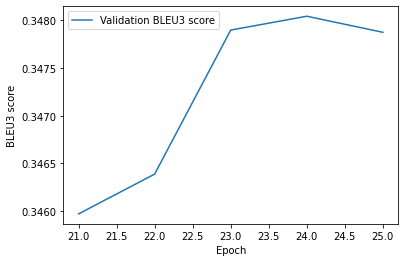

In [59]:
plt.plot(val_epoch_array, val_bleu3_array, label = 'Validation BLEU3 score')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('BLEU3 score')
plt.show()

### Predict

In [50]:
import rouge

In [51]:
def rouge_score(reference, hypothesis):

    evaluator = rouge.Rouge(metrics=['rouge-l'])
    return evaluator.get_scores([hypothesis], [reference])['rouge-l']['f']

In [57]:
def predict(model, val_loader, vocab):
    
    model.eval()

    rouge_scores = []
    bleu1_scores = []
    bleu2_scores = []
    bleu3_scores = []
    bleu4_scores = []

    with torch.no_grad():
        for i, (images, semantic_inputs, captions, lengths) in enumerate(val_loader):
            images = images.to(device)
            semantic_inputs = semantic_inputs.to(device)
            captions = captions.to(device)
            caption = captions[0]
            
            image_feats = encoder(images)
            image_feats = image_feats.unsqueeze(1).squeeze(3).squeeze(3)
            
            caption_list = [vocab.get_word(wid.item()) for wid in caption if wid != 0]                
            caption_list = caption_list[1:-1]
            caption_sentence = ' '.join(caption_list)
            
            output = model(image_feats, 12, semantic_inputs, None, beam=5)
            output = output[1][1:-1] if output[1][-1] == end_token else output[1][1:]
            output_sentence = ' '.join(output)
            
            print("Ref:", caption_sentence)
            print("Hyp:", output_sentence)

            rouge_scores.append(rouge_score(caption_sentence, output_sentence))
            bleu1_scores.append(bleu_score(caption_list, output, 1))
            bleu2_scores.append(bleu_score(caption_list, output, 2))
            bleu3_scores.append(bleu_score(caption_list, output, 3))
            try:
                bleu4_scores.append(bleu_score(caption_list, output, 4))
            except:
                bleu4_scores.append(0)
            
#             if i % 500 == 0:
#                 print(i)
            if i == 2:
                break
            
    rouge_score_avg = sum(rouge_scores)/len(rouge_scores)
    bleu1_score_avg = sum(bleu1_scores)/len(bleu1_scores)
    bleu2_score_avg = sum(bleu2_scores)/len(bleu2_scores)
    bleu3_score_avg = sum(bleu3_scores)/len(bleu3_scores)
    bleu4_score_avg = sum(bleu4_scores)/len(bleu4_scores)
    
    return rouge_score_avg, bleu1_score_avg, bleu2_score_avg, bleu3_score_avg, bleu4_score_avg

In [58]:
pred_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=collate_fn)

In [59]:
rouge_score_avg, bleu1_score_avg, bleu2_score_avg, bleu3_score_avg, bleu4_score_avg = predict(caption_model, pred_loader, vocab)

Ref: lilac lustre nail polish
Hyp: streetwear mauve nail polish
Ref: women silk green kurta
Hyp: fabindia women green kurta
Ref: women freestyle sports analog steel black watch
Hyp: fastrack women white dial watch


In [56]:
print(rouge_score_avg, bleu1_score_avg, bleu2_score_avg, bleu3_score_avg, bleu4_score_avg)

0.5277777777777778 0.5060426728047519 0.30274943015462097 1.1065708905209323e-103 6.6928657911675046e-155
